# PORTFOLIO OPTIMISATION

**This project aims at optimising any given portfolio of financial stock assets in order to maximise the return whilst having minimum risk**

In [44]:
# import the necessary python libraries

import pandas as pd
import numpy as np
from datetime import datetime

# Visualisation Libraries
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


# Utility Scripts
from data_loader import get_closing_prices

In [45]:
# Tickers of the Stocks to examine within the portfolio
tickers = ['META','AMZN','AAPL', 'GOOG', 'NFLX']

# date range of the stocks
start_date = '2013-01-01'
todays_date = datetime.today().strftime('%Y-%m-%d')
# todays_date = '2020-03-16'
time_interval = 'daily'

# Create the data-source object and fetch the stocks data
df = get_closing_prices(tickers, start_date, todays_date, time_interval)

In [46]:
df.head()

,META,AMZN,AAPL,GOOG,NFLX
Date,,,,,
2013-01-02,28.000000,12.8655,19.608213,18.013729,13.144286
2013-01-03,27.770000,12.9240,19.360714,18.024191,13.798571
2013-01-04,28.760000,12.9575,18.821428,18.380356,13.711429
2013-01-07,29.420000,13.4230,18.710714,18.300158,14.171429
2013-01-08,29.059999,13.3190,18.761070,18.264042,13.880000


In [47]:
# initialising the weights of the assets in the portfolio 
# balanced weights (initiallialy all weighing the same)

weights = np.array([1/len(tickers) for t in tickers])
weights

array([0.2, 0.2, 0.2, 0.2, 0.2])

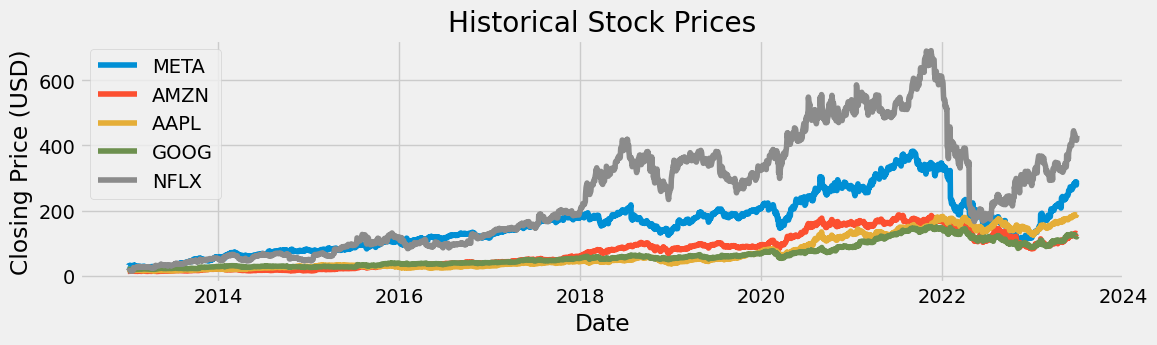

In [48]:
# lets visualise each of these Stocks closing prices
plt.figure(figsize=(12, 3))
for column in df.columns:
    plt.plot(df.index, df[column], label=column)

# Add a title and labels
plt.title("Historical Stock Prices")
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")

# Add a legend to the plot
plt.legend(loc="upper left")

# Display the plot
plt.show()

**Calculating the Daily Returns**

In [49]:
returns = df.pct_change()
returns

,META,AMZN,AAPL,GOOG,NFLX
Date,,,,,
2013-01-02,NaN,NaN,NaN,NaN,NaN
2013-01-03,-0.008214,0.004547,-0.012622,0.000581,0.049777
2013-01-04,0.035650,0.002592,-0.027855,0.019760,-0.006315
2013-01-07,0.022949,0.035925,-0.005882,-0.004363,0.033549
2013-01-08,-0.012237,-0.007748,0.002691,-0.001974,-0.020565
...,...,...,...,...,...
2023-06-22,0.011504,0.042618,0.016525,0.021524,-0.004641
2023-06-23,0.013514,-0.006300,-0.001711,-0.006862,0.003645
2023-06-26,-0.035535,-0.015464,-0.007553,-0.031946,-0.019056


**Displaying the annualised Covariance Matrix**

In [50]:
cov_matrix_annual = returns.cov() * 252 #where 252 is the number of business days
cov_matrix_annual

,META,AMZN,AAPL,GOOG,NFLX
META,0.149884,0.069173,0.053609,0.063438,0.074440
AMZN,0.069173,0.107333,0.047662,0.056714,0.073927
AAPL,0.053609,0.047662,0.082806,0.044956,0.043591
GOOG,0.063438,0.056714,0.044956,0.075364,0.055866
NFLX,0.074440,0.073927,0.043591,0.055866,0.224128


In [51]:
# Calculating the variance of the Portfolio
port_variance = np.dot( weights.T, np.dot(cov_matrix_annual,weights))
port_variance

0.07225069498397087

In [52]:
# Calculating the volatility (std dev of the porfolio)
port_volitility = np.sqrt(port_variance)
port_volitility

0.2687948938949006

In [53]:
# Calculating the annual portfolio return
port_simple_return = np.sum(returns.mean() * weights) * 252
port_simple_return

0.29852882627852256

In [54]:
# Displaying the expected return, volatility and variance


print(f'Expected annual return: {port_simple_return*100 :.2f}%')
print(f'Annual volitility or risk: {port_volitility*100 :.2f}%')
print(f'Annual variance: {port_variance*100 :.2f}%')

Expected annual return: 29.85%
Annual volitility or risk: 26.88%
Annual variance: 7.23%


In [55]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [56]:
# Optimising the Portfolio

# Expected returns
mu = expected_returns.mean_historical_return(df)

# Annalised covariance matrix of asset returns
S = risk_models.sample_cov(df)

# optimising for the highest Sharpe ratio
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights  = ef.clean_weights() # performs rounding
print(cleaned_weights)
ef.portfolio_performance(verbose = True)

OrderedDict([('META', 0.02779), ('AMZN', 0.1302), ('AAPL', 0.48695), ('GOOG', 0.02963), ('NFLX', 0.32543)])
Expected annual return: 29.1%
Annual volatility: 27.9%
Sharpe Ratio: 0.97


(0.2911745042993104, 0.2787669041986145, 0.9727643425924954)

**Allocation of funcds to the various Assets**

In [59]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

total_val = 15000
latest_prices = get_latest_prices(df)
weights = cleaned_weights
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value = total_val)

allocation, leftover = da.lp_portfolio()
print(f'Discrete allocation: {allocation}')
print(f'Remaining funds: ${leftover :.2f}')

Discrete allocation: {'META': 1, 'AMZN': 15, 'AAPL': 39, 'GOOG': 4, 'NFLX': 11}
Remaining funds: $185.80
